In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import time 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
#from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
#from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import itertools
import xgboost as xgb
from sklearn.svm import SVR
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor

In [2]:
#def normalize_column(col):
#    return (col - np.mean(col)) / np.std(col)

#def scale_minmax(col):
#    return (col-col.min())/(col.max()-col.min())

def get_score(model, X, y_true):
    y_pred = model.predict(X)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_precision_error(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data gathering 

In [3]:
data      = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/test.csv')

data      = data.dropna(axis = 0)

test_data.loc[12577, 'distanceKM']      = 52
test_data.loc[12577, 'taxiDurationMin'] = 50
test_data.loc[13853, 'distanceKM']      = 500
test_data.loc[13853, 'taxiDurationMin'] = 380

all_data = pd.concat((data, test_data)) 

min_price = min(all_data['price'])

ntrain = data.shape[0]
ntest  = test_data.shape[0]

BUCKET_LATI = 1000
BUCKET_LONG = 1000

min_source_lat  = min(all_data['sourceLatitude'])
min_destin_lat  = min(all_data['destinationLatitude'])
min_lat         = min(min_destin_lat, min_source_lat)

min_source_long = min(all_data['sourceLongitude'])
min_destin_long = min(all_data['destinationLongitude'])
min_long        = min(min_destin_long, min_source_long)

max_source_lat  = max(all_data['sourceLatitude'])
max_destin_lat  = max(all_data['destinationLatitude'])
max_lat         = max(max_destin_lat, max_source_lat)

max_source_long = max(all_data['sourceLongitude'])
max_destin_long = max(all_data['destinationLongitude'])
max_long        = max(max_destin_long, max_source_long)

d_lati = (max_lat - min_lat)/BUCKET_LATI
d_long = (max_long - min_long)/BUCKET_LONG

destin_lati_bucket = (all_data['destinationLatitude']  // d_lati).as_matrix().astype(int)
destin_long_bucket = (all_data['destinationLongitude'] // d_long).as_matrix().astype(int)

all_data['destination_tuple'] = tuple(zip(destin_lati_bucket,destin_long_bucket))

source_lati_bucket = (all_data['sourceLatitude']  // d_lati).as_matrix().astype(int)
source_long_bucket = (all_data['sourceLongitude'] // d_long).as_matrix().astype(int)

all_data['source_tuple'] = tuple(zip(source_lati_bucket,source_long_bucket))


categorical_vars = ['date', 'SourceState', 'destinationState', 'vehicleType', 
                    'vehicleOption', 'source_tuple', 'destination_tuple']

all_data = all_data.copy()
categorical_var_encoders = {}
for var in categorical_vars:
    le = preprocessing.LabelEncoder().fit(all_data[var])
    all_data[var + '_ids']  = le.transform(all_data[var])
    all_data[var + '_ids']  = all_data[var + '_ids'].astype('int32')
    all_data.pop(var)
    categorical_var_encoders[var] = le

all_data['source']           = all_data['sourceLatitude']*all_data['sourceLongitude']
all_data['destination']      = all_data['destinationLatitude']*all_data['destinationLongitude']

#categorical_var_encoders['SourceState'].classes_
    
train    = all_data[:ntrain]
test     = all_data[ntrain:]

X = train.drop(['ID','price'],axis=1)
y = train.price

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,destinationLatitude,destinationLongitude,distanceKM,sourceLatitude,sourceLongitude,taxiDurationMin,weight,date_ids,SourceState_ids,destinationState_ids,vehicleType_ids,vehicleOption_ids,source_tuple_ids,destination_tuple_ids,source,destination
39085,36.473089,52.349822,184.0,35.700109,51.399743,199.0,21.00,124,7,19,3,2,1410,1774,1834.976428,1909.359717
30892,35.704176,51.400280,331.0,37.275731,49.584392,254.0,1.67,118,29,7,1,5,1926,1515,1848.294458,1835.204644
45277,35.699924,51.396715,447.0,32.665899,51.663805,285.0,19.00,83,3,7,3,7,801,1515,1687.644636,1834.858819
16398,30.199563,53.182966,809.0,35.699078,51.401589,525.0,4.00,151,7,15,1,5,1410,463,1834.989335,1606.102332
13653,27.180941,56.277756,1144.0,34.643252,50.877469,750.0,2.00,85,17,21,1,5,1176,72,1762.560980,1529.682365


# Initial Modelling

In [ ]:
LGBF = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                          learning_rate=0.05, n_estimators=15000,
                          max_bin = 1000, bagging_fraction = 0.6,
                          bagging_freq = 5, feature_fraction = 0.25,
                          feature_fraction_seed=9, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

GBSTF = GradientBoostingRegressor(n_estimators=3200, learning_rate=0.05,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

XGBF = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=10, 
                        min_child_weight=1.7817, n_estimators=2200,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213, silent=1,
                        random_state =5 , nthread = -1)

BAGF = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=1.0, random_state=5, verbose=1)
DECF  = DecisionTreeRegressor(max_depth=15)
RFSTF = RandomForestRegressor(n_estimators=20, criterion='mae', 
                              max_depth=4, max_features='sqrt',
                              min_samples_leaf=5, min_samples_split =3, random_state = 42)

KNNF = KNeighborsClassifier(2)
LASSF = Lasso(fit_intercept = True)
ABSTF = AdaBoostRegressor(n_estimators=1000, learning_rate=0.05, loss='linear', random_state=5)

SVRF = SVR()
RDGF = Ridge()
ENTF = make_pipeline(RobustScaler(), ElasticNet(alpha=0.8, l1_ratio=.9, random_state=3))

models = { "Gboost": GBSTF, "xgb": XGBF, "bagging": BAGF, "lgbm": LGBF, "dec_tree": DECF, "Random_forest": RFSTF,
          "knn": KNNF, "elasticNet": ENTF, "ridge": RDGF, "lasso": LASSF, "AdaBoost": ABSTF, "SVR": SVRF}

for model_name in models:
    model = models[model_name]
    start_time = time.time()
    model.fit(X_train, y_train)
    train_cols = X_train.columns.tolist()
    X_val['y_' + model_name] = model.predict(X_val[train_cols])
    #stackedset = pd.concat([stackedset, pd.DataFrame(y_pred, columns=[model_name])], axis=1)
    score = mean_absolute_precision_error(X_val['y_' + model_name], y_val)
    print(model_name, '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)

X_val.to_pickle('dataFrames/X_val.pkl')
# Gboost,        4.35 mins, score=  17.21
# xgb,           1.99 mins, score=  18.17
# bagging,       0.67 mins, score=  19.14
# lgbm,          1.07 mins, score=  20.03
# dec_tree,      0.01 mins, score=  23.41
# Random_forest, 4.58 mins, score=  30.52
# knn,           0.00 mins, score=  32.04
# elasticNet,    0.00 mins, score=  38.47 
# ridge,         0.00 mins, score=  40.90
# lasso,         0.02 mins, score=  40.91 
# AdaBoost,      0.77 mins, score=  57.33 
# SVR,           0.63 mins, score=  72.84 
# KernelRidge and LinearRegression() take more than 1 hour to run! Don't Run them. 

In [ ]:
ridge = Ridge()

clf_ridge = GridSearchCV(ridge, {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}, verbose=1)

clf_ridge.fit(X_train,y_train)
print(clf_ridge.best_params_)
get_score(clf_ridge,X_val,y_val)
# 40.78025846231952

In [ ]:
lasso = Lasso()

clf_lasso = GridSearchCV(lasso, {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}, verbose=1)
clf_lasso.fit(X_train,y_train)
print(clf_lasso.best_params_)
get_score(clf_lasso,X_val,y_val)
# {'alpha': 100.0}
# 40.78453998923231

In [ ]:
reg_lassolars  =  linear_model.LassoLars(alpha = 2)
reg_lassolars.fit(X_train, y_train)
get_score(reg_lassolars,X_val,y_val)
# 40.775030093207896

In [ ]:
reg_dec_tree = DecisionTreeRegressor(max_depth=10, criterion = 'mae', max_features='sqrt',
                                     random_state=5, min_samples_leaf = 12, min_samples_split = 2)
reg_dec_tree.fit(X_train, y_train)
get_score(reg_dec_tree,X_val,y_val)
# 26.002284134401865

In [ ]:
#dec_tree = DecisionTreeRegressor()

#clf_dec_tree = GridSearchCV(dec_tree, 
#                            {'criterion' : ['mae'], 
#                             'max_depth' : [2,4,6,8,10,12,14,16,18,20,22,24],
#                             'min_samples_split' : [2,4,6,8,10], 
#                             'min_samples_leaf' : [2,4,6,8,10,12,14,16,18,20,22,24],
#                             'max_features' : ['sqrt'], 
#                             'random_state' : [5]
#                            }, verbose=1)
#clf_dec_tree.fit(X_train,y_train)
#print(clf_dec_tree.best_params_)
#get_score(clf_dec_tree,X_val,y_val)

In [ ]:
# Computationally intensive 
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#KRR.fit(X_train, y_train)
#get_score(KRR,X_val,y_val)

# score = 33.473933712491295

In [ ]:
# Very computationally expensive
#BAYSR = BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, 
#                      compute_score=True, fit_intercept=True, normalize=True)
#BAYSR.fit(X_train, y_train)
#get_score(BAYSR,X_val,y_val)

# Plotting predictions

In [4]:
X_val = pd.read_pickle('dataFrames/X_val.pkl')
X_val.head()

,destinationLatitude,destinationLongitude,distanceKM,sourceLatitude,sourceLongitude,taxiDurationMin,weight,date_ids,SourceState_ids,destinationState_ids,...,y_bagging,y_lgbm,y_dec_tree,y_Random_forest,y_knn,y_elasticNet,y_ridge,y_lasso,y_AdaBoost,y_SVR
33553,36.471723,52.871692,1408.0,27.181578,56.278461,995.0,2.0,171,21,19,...,9583760.0,9.101787e+06,1.354800e+07,9070875.0,27550000.0,1.127905e+07,1.249048e+07,1.248484e+07,1.026197e+07,4.319999e+06
9427,29.611462,52.532224,1133.0,35.021640,58.786047,779.0,10.0,30,9,15,...,7680960.0,1.188064e+07,7.500000e+06,7353075.0,4085000.0,7.459714e+06,7.138929e+06,7.134694e+06,1.035664e+07,4.319999e+06
199,32.676185,51.671182,673.0,37.193824,50.150938,488.0,3.0,5,29,3,...,3546820.0,2.788512e+06,4.356120e+06,4376100.0,4200000.0,4.287717e+06,4.638098e+06,4.644116e+06,5.039455e+06,4.319999e+06
12447,37.393011,46.238081,1062.0,32.252484,54.010156,712.0,15.0,181,30,0,...,12369920.0,1.109417e+07,1.359750e+07,8097775.0,12500000.0,1.001661e+07,1.009162e+07,1.008731e+07,1.147813e+07,4.319999e+06
45079,30.403944,56.000462,251.0,31.881874,54.359440,167.0,15.0,177,30,25,...,3823320.0,3.846560e+06,4.389667e+06,3769950.0,2530000.0,3.741553e+06,3.642086e+06,3.624332e+06,3.927970e+06,4.319999e+06


In [5]:
pred_cols = ['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm', 'y_dec_tree', 'y_Random_forest', 'y_knn',
             'y_elasticNet', 'y_ridge', 'y_lasso', 'y_AdaBoost', 'y_SVR']

best_cols = ['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm']
best_pred = X_val[list(best_cols)]
best_pred.head()

,y_Gboost,y_xgb,y_bagging,y_lgbm
33553,9.223762e+06,10949136.0,9583760.0,9.101787e+06
9427,8.983816e+06,9287964.0,7680960.0,1.188064e+07
199,3.123097e+06,3404336.0,3546820.0,2.788512e+06
12447,1.145880e+07,11581276.0,12369920.0,1.109417e+07
45079,4.250560e+06,4501707.5,3823320.0,3.846560e+06


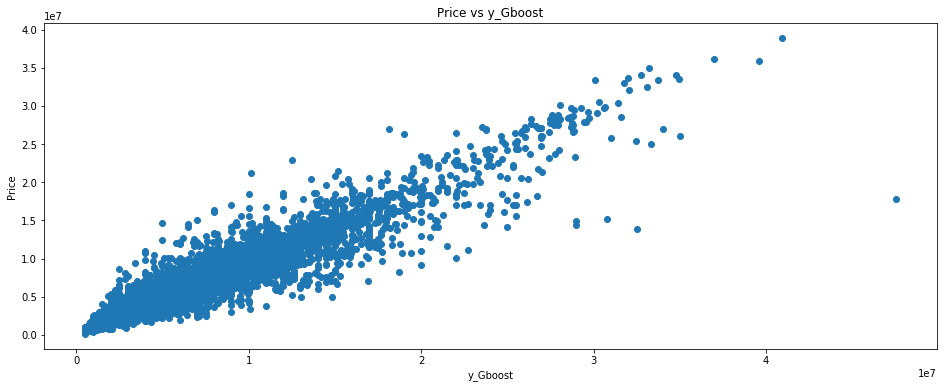

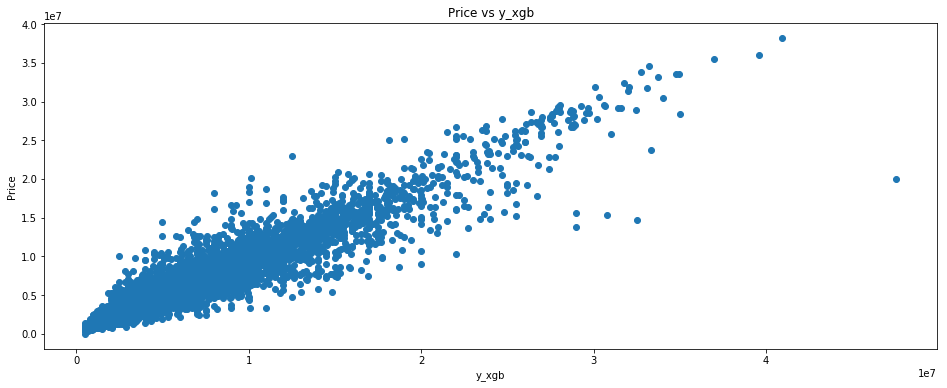

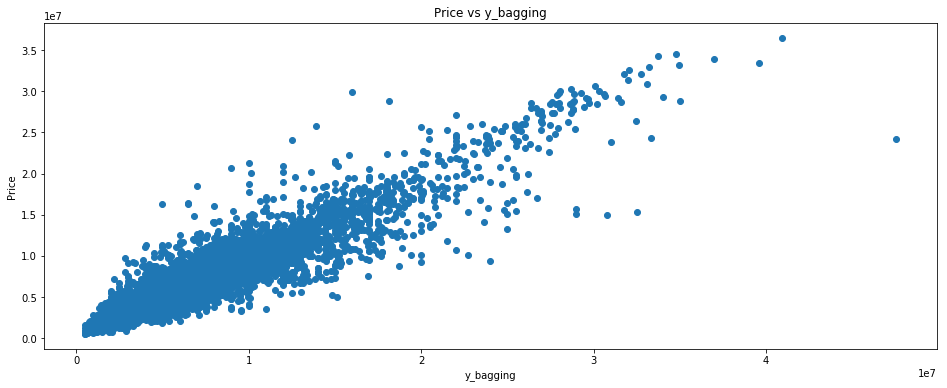

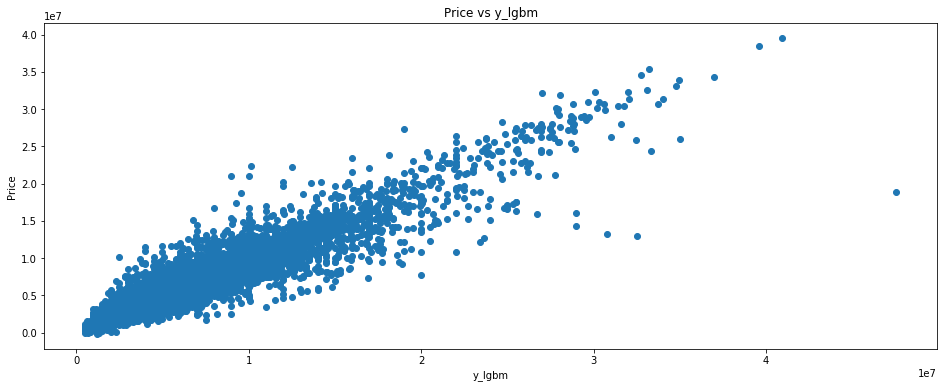

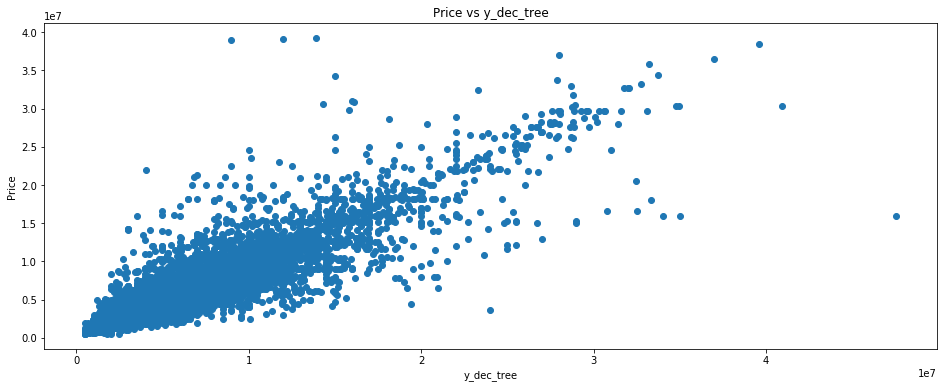

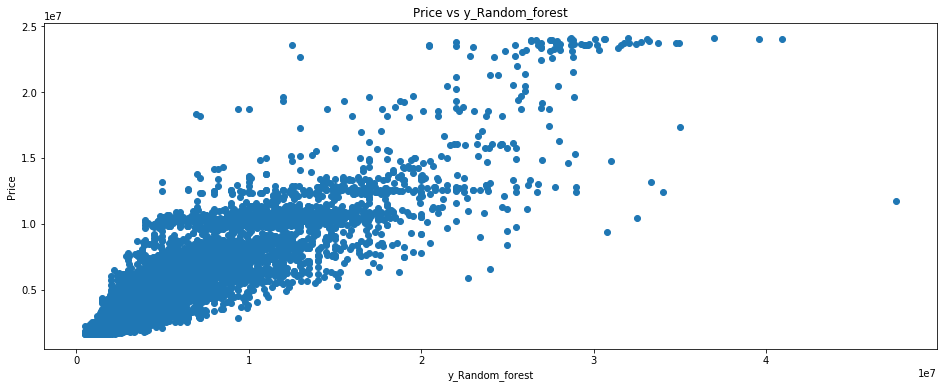

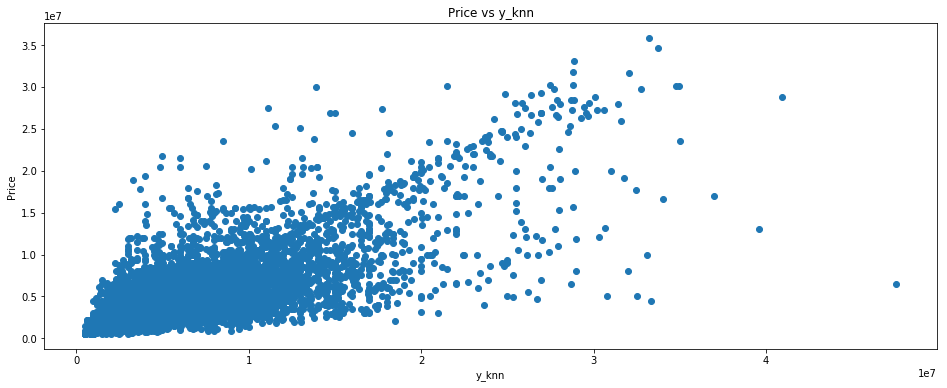

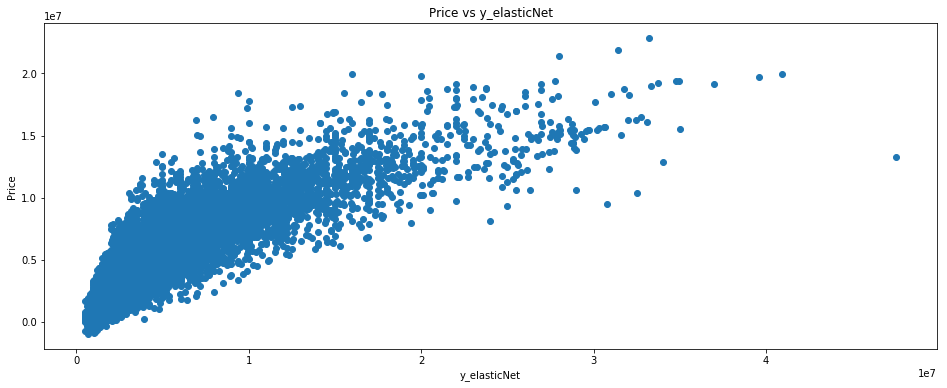

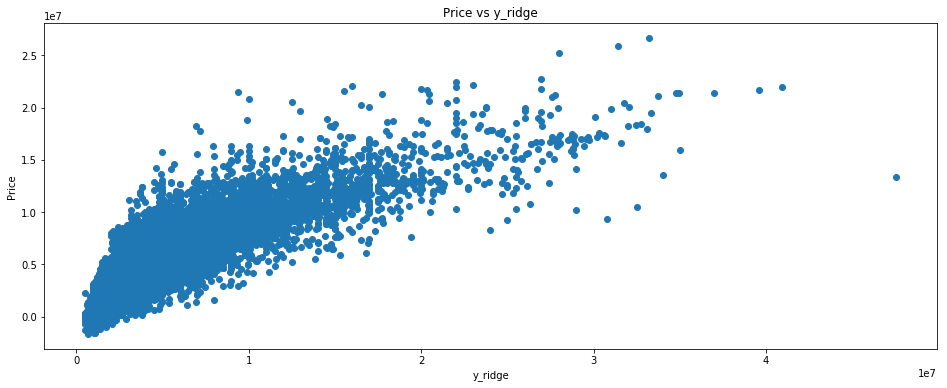

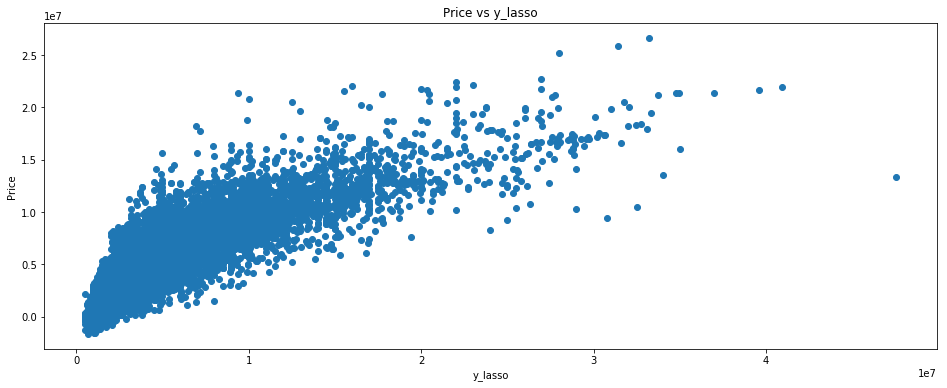

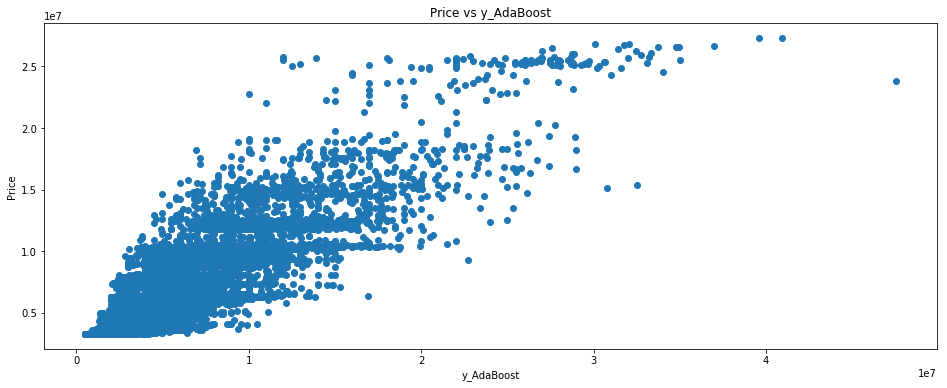

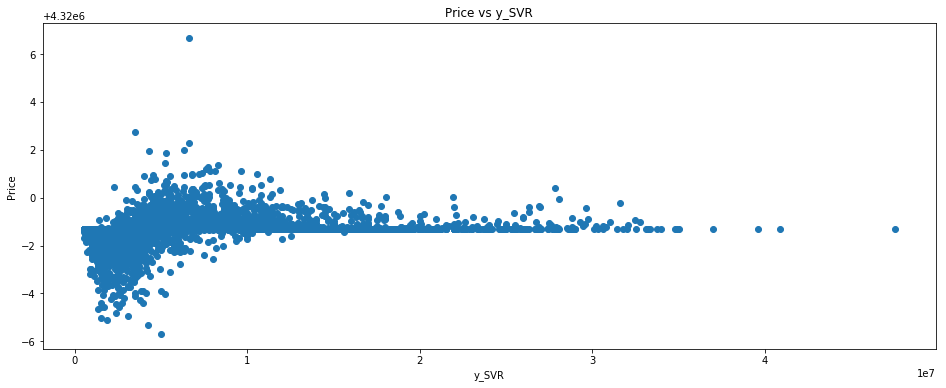

In [6]:
for col in pred_cols:
    plt.figure(figsize=(16,6))
    plt.scatter(y_val, X_val[col])
    plt.title('Price vs '+ col)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

# Stacking

### Testing self stacking

In [10]:
lst = list(itertools.product([0, 1], repeat= len(best_cols)))

opt_comb  = lst[0]
opt_score = 1e500000

for i in range(1,len(lst)):
    A = lst[2**(len(best_cols))-i]
    selected_cols = []
    for i in range(len(best_cols)):
        if A[i]:
            selected_cols.append(best_cols[i])
    Xstack = np.array(best_pred[selected_cols])
    l1_stacked  = Lasso(alpha = 0.0001,fit_intercept = True)
    l1_stacked.fit(Xstack, y_val)
    l1_score = get_score(l1_stacked, Xstack, y_val)
    
    if l1_score < opt_score:
        opt_score = l1_score
        opt_comb = lst[i]
    print(i, '%.2f' % l1_score, A )
print("optimal choice: ", '%.2f' % opt_score, opt_comb)

3 17.47 (1, 1, 1, 1)
3 17.51 (1, 1, 1, 0)
3 17.51 (1, 1, 0, 1)
3 17.55 (1, 1, 0, 0)
3 17.48 (1, 0, 1, 1)
3 17.50 (1, 0, 1, 0)
3 17.58 (1, 0, 0, 1)
3 17.62 (1, 0, 0, 0)
3 17.84 (0, 1, 1, 1)
3 17.96 (0, 1, 1, 0)
3 18.07 (0, 1, 0, 1)
3 101.24 (0, 1, 0, 0)
3 18.40 (0, 0, 1, 1)
3 19.08 (0, 0, 1, 0)
3 20.35 (0, 0, 0, 1)
optimal choice:  17.47 (0, 0, 1, 1)


In [8]:
A = lst[2**(len(best_cols))-1]
selected_cols = []
for i in range(len(best_cols)):
    if A[i]:
        selected_cols.append(best_cols[i])
Xstack = np.array(best_pred[selected_cols])
print(selected_cols)
y_mean = np.mean(Xstack,axis=1)
mean_absolute_precision_error(y_mean,y_val)

# ['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm']
# 17.522228479312353

['y_Gboost', 'y_xgb', 'y_bagging', 'y_lgbm']


17.522228479312353

In [9]:
y_prod_avg = (Xstack[:,0]*Xstack[:,1]*Xstack[:,2]*Xstack[:,3])**(1.0/4.0)
mean_absolute_precision_error(y_prod_avg,y_val)

# 17.415549371458187

17.415549371458187

### Testing stackingRegressor

Look at the following link: https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe

#### Creating base estimators

In [11]:
LGBF = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                          learning_rate=0.05, n_estimators=15000,
                          max_bin = 1000, bagging_fraction = 0.6,
                          bagging_freq = 5, feature_fraction = 0.25,
                          feature_fraction_seed=9, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

GBSTF = GradientBoostingRegressor(n_estimators=3200, learning_rate=0.05,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

XGBF = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=10, 
                        min_child_weight=1.7817, n_estimators=2200,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213, silent=1,
                        random_state =5 , nthread = -1)

BAGF  = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=1.0, random_state=5, verbose=1)
DECF  = DecisionTreeRegressor(max_depth=15)
KNNF  = KNeighborsClassifier(2)
LASSF = Lasso(fit_intercept = True)
RDGF  = Ridge()
ENTF  = make_pipeline(RobustScaler(), ElasticNet(alpha=0.8, l1_ratio=.9, random_state=3))

models = { "Gboost": GBSTF, "xgb": XGBF, "bagging": BAGF, "lgbm": LGBF, "dec_tree": DECF, 
          "knn": KNNF, "elasticNet": ENTF, "ridge": RDGF, "lasso": LASSF}

for model_name in models:
    model = models[model_name]
    start_time = time.time()
    model.fit(X_train, y_train)
    train_cols = X_train.columns.tolist()
    X_val['y_' + model_name] = model.predict(X_val[train_cols])
    score = mean_absolute_precision_error(X_val['y_' + model_name], y_val)
    print(model_name, '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)

Gboost 4.46 mins, score=  17.21
xgb 2.09 mins, score=  18.17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


bagging 0.68 mins, score=  19.14
lgbm 1.13 mins, score=  20.03
dec_tree 0.01 mins, score=  23.38
knn 0.02 mins, score=  32.04
elasticNet 0.00 mins, score=  38.47
ridge 0.00 mins, score=  40.90
lasso 0.02 mins, score=  40.91


#### Training the Meta model

In [16]:
regressors = [XGBF, BAGF, LGBF]
stregr     = StackingRegressor(regressors=regressors, meta_regressor=GBSTF)
start_time = time.time()
stregr.fit(X_train, y_train)
y_pred = stregr.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("stackingRegressor model", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)
# stackingRegressor model 6.27 mins, score=  18.20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


stackingRegressor model 6.27 mins, score=  18.20


In [17]:
regressors = [XGBF, BAGF, LGBF, DECF, KNNF, LASSF, RDGF, ENTF]
stregr     = StackingRegressor(regressors=regressors, meta_regressor=GBSTF)
start_time = time.time()
stregr.fit(X_train, y_train)
y_pred = stregr.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("stackingRegressor model", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score= ", '%.2f' % score)
# stackingRegressor model 7.62 mins, score=  19.22

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


stackingRegressor model 7.62 mins, score=  19.22


In [ ]:
#regressors = [GBSTF, XGBF, BAGF, LGBF]
#stregr     = StackingRegressor(regressors=regressors, meta_regressor=LASSF)

#params = {'xgbregressor__n_estimators': [2000],#[100, 200, 500, 1000],
#          'xgbregressor__max_depth': [8],#[2,4,8,16],
#          'meta-gradientboostingregressor__n_estimators': [2000],#[100, 200, 500, 1000],
#          'meta-gradientboostingregressor__max_depth': [48],#[2,4,8,16],
#          'baggingregressor__base_estimator': [KNeighborsRegressor()]}#, DecisionTreeRegressor()]}

#grid = GridSearchCV(estimator=stregr, 
#                    param_grid=params, 
#                    cv=3,
#                    refit=True)
#grid.fit(X_train, y_train)
#print(grid.best_params_)
#get_score(grid,X_val,y_val)

### Testing another stacking method

Look at the following link:
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

#### Averaged base models class

In [18]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [19]:
start_time = time.time()
averaged_models = AveragingModels(models = (XGBF, GBSTF, BAGF))
averaged_models.fit(X_train, y_train)
y_pred = averaged_models.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("Average models", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score =", '%.2f' % score)
# Average models 7.45 mins, score=  17.54

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.5s finished


stackingRegressor model 7.45 mins, score=  17.54


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


#### Stacking Averaged models Score

In [20]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                #instance.fit(X[train_index], y[train_index])
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [21]:
start_time = time.time() 
stacked_averaged_models  = StackingAveragedModels(base_models = (XGBF, BAGF), meta_model = GBSTF)
stacked_averaged_models.fit(X_train, y_train)
y_pred = stacked_averaged_models.predict(X_val[train_cols])
score  = mean_absolute_precision_error(y_pred, y_val)
print("stacking Averaged models", '%.2f' % float((time.time() - start_time)/60 ) +" mins, score =", '%.2f' % score)
# stacking Averaged models 13.63 mins, score=  18.68

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]

stacking Averaged models 13.63 mins, score=  18.68


# Trying a new model for each Vehicle Type

In [ ]:
vTypes = set(all_data['vehicleType_ids'])
all_vType     = {}
final_models  = {}

for i in vTypes:
    tmp_vType = all_data[all_data['vehicleType_ids'] == i]
    #tmp_vType = tmp_vType.drop(['vehicleType_ids'], axis=1)
    all_vType[i] = tmp_vType
    start_time = time.time()
    vType_train = tmp_vType[tmp_vType['price'].notnull()]
    vType_test  = tmp_vType[tmp_vType['price'].isnull()].drop(['price'], axis=1)
    X = vType_train.drop(['ID','price', 'vehicleType_ids'],axis=1)
    y = vType_train['price']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

    if i != 1:
        minSampleLeaf = 20 
    else:
        minSampleLeaf = 15
    
    if i != 3:
        nEstimators = 1000
        minSampleSplit = 4
    else:
        nEstimators = 1500
        minSampleSplit = 2
    
    GBoost = GradientBoostingRegressor(learning_rate=0.1, max_features='sqrt', loss='huber',
                                       min_samples_leaf=minSampleLeaf, min_samples_split=minSampleSplit, 
                                       n_estimators=nEstimators, max_depth=8, alpha = 0.7)
    
    GBoost.fit(X_train,y_train)
    
    print("%.2f" % float((time.time() - start_time)/60 ) +" mins, vType: ",i, ", items: ", tmp_vType.shape[0],
          ", loss: ", "%.2f" % get_score(GBoost,X_val,y_val))
    
    GB_Final = GradientBoostingRegressor(learning_rate=0.1, max_features='sqrt', loss='huber',
                                         min_samples_leaf=minSampleLeaf, min_samples_split=minSampleSplit, 
                                         n_estimators=nEstimators, max_depth=8, alpha = 0.7)
    
    GB_Final.fit(X,y)
    final_models[i] = GB_Final  
    
    #clf_GBoost = GridSearchCV(GBoost, 
    #                      {
    #                       'min_samples_split': [2,4],
    #                       'n_estimators': [1000,1500], 
    #                       'max_depth': [4,8],
    #                       'min_samples_leaf': [20,15],
    #                      },  verbose=2)

    #clf_GBoost.fit(X_train,y_train)
    #, best model: ", GBoost.get_params)# clf_GBoost.best_params_) 

In [ ]:
filename = "/Users/mohsenkiskani/Downloads/Ubaar/submissions/submission15.csv"
with open(filename,"w+") as outputfile:
    outputfile.write("ID,price\n")        
    
    for i in final_models.keys():
        tmp_test0            = test[test['vehicleType_ids']==i]
        tmp_test1            = tmp_test0.drop(['ID', 'price', 'vehicleType_ids'], axis=1)
        tmp_model            = final_models[i]
        tmp_test0['y_pred']  = tmp_model.predict(tmp_test1)
    
        for j in range(tmp_test0.shape[0]):
            y_pred_test = tmp_test0.iloc[j]['y_pred'] 
            if y_pred_test < 0:
                y_pred_test = min_price 
            outputfile.write(str(int(tmp_test0.iloc[j]['ID'] ))+","+str(int(np.ceil(y_pred_test)))+"\n")

# Trying a new model for each Vehicle Type and Vehicle Option ?

In [ ]:
all_cats2 = all_data[['vehicleType_ids', 'vehicleOption_ids']].as_matrix().tolist()
all_cats2 = [(x[0],x[1]) for x in all_cats2 ]
all_cats2 = set(all_cats2)
all_data_cat2 = {}

for item in all_cats2:
    tmp_data1 = all_data[all_data['vehicleType_ids'] == item[0]]
    tmp_data2 = tmp_data1[tmp_data1['vehicleOption_ids'] == item[1]]
    tmp_data = tmp_data2.drop(['vehicleType_ids', 'vehicleOption_ids'], axis=1)
    all_data_cat2[item] = tmp_data
    #print(item, tmp_data.shape)

In [ ]:
all_data_cat_shape2 = {}
for x in all_data_cat2.keys():
    
    cat_df2    = all_data_cat2[x]
    cat_train2 = cat_df2[cat_df2['price'].notnull()]
    cat_test2  = cat_df2[cat_df2['price'].isnull()].drop(['price'], axis=1)
    
    all_data_cat_shape2[x] = (cat_train2.shape[0], cat_test2.shape[0])

In [ ]:
test_sum = pd.DataFrame() 
for item in  [(1,6)]: # all_cats2: 
    start_time = time.time()
    
    cat_df2    = all_data_cat2[item]
    cat_train2 = cat_df2[cat_df2['price'].notnull()]
    cat_test2  = cat_df2[cat_df2['price'].isnull()].drop(['price'], axis=1)

    X = cat_train2.drop(['ID','price'],axis=1)
    y = cat_train2['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

    #gboost_base = GradientBoostingRegressor()
    #GBoost      = GridSearchCV(gboost_base,
    #                   {'max_depth': [2,4,6,8,10,12],
    #                    'n_estimators': [50,100,200,500,1000]}, verbose=1)



    GBoost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                       max_depth=6, max_features='sqrt',
                                       min_samples_leaf=8, min_samples_split=4, 
                                       loss='huber', random_state =5)

    GBoost.fit(X_train, y_train)
    #print(GBoost.best_params_)
    #'destinationLatitude','destinationLongitude','sourceLatitude','sourceLongitude',
    print(item, cat_df2.shape[0], "%.2f" % get_score(GBoost,X_val,y_val),
          "%.2f" % float((time.time() - start_time)/60 )) 


#cat_test['pred_price'] = GBoost.predict(cat_test.drop(['ID'], axis=1))
#cat_test['pred_price'] = cat_test['pred_price'].apply((lambda x: max(x, min_price) ))
#test_sum = pd.concat([test_sum,cat_test])

#test_sum.shape

# Final model

In [ ]:
# Current best model 
start_time = time.time()
Final = GradientBoostingRegressor(n_estimators=2200, learning_rate=0.05,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
Final.fit(train.drop(['ID','price'],axis=1), train.price)
y_pred_test = Final.predict(test.drop(['ID','price'],axis=1))
print( '%.2f' % float((time.time() - start_time)/60 ) )

# Save to file

In [ ]:
filename = "/Users/mohsenkiskani/Downloads/Ubaar/submissions/submission17.csv"
with open(filename,"w+") as outputfile:
    outputfile.write("ID,price\n")
    for i in range(y_pred_test.shape[0]):
        if y_pred_test[i] < 0:
            y_pred_test[i] = 100000 
        outputfile.write(str(test_data.ID[i])+","+str(int(np.ceil(y_pred_test[i])))+"\n")

### Deal with high skewness

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

#print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
#print(skewness.head(10))

skewness = skewness[abs(skewness) > 0.75]
#print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

# Plots 

In [ ]:
fig1, (ay1, ay2) = plt.subplots(2, 1)


ay1.scatter(x = X_train['sourceLatitude'], y = y_train, marker = "+")
ay1.set_title('Price vs sourceLatitude')
ay1.set_xlabel('sourceLatitude')
ay1.set_ylabel('Price')

ay2.scatter(x = X_train['sourceLongitude'], y = y_train, marker = "+")
ay2.set_title('Price vs sourceLongitude')
ay2.set_xlabel('sourceLongitude')
ay2.set_ylabel('Price')

fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/sourceEffects.png", dpi=100)
plt.show()

In [ ]:
fig2, (ay3, ay4) = plt.subplots(2, 1)


ay3.scatter(x = X_train['destinationLatitude'], y = y_train, marker = "+")
ay3.set_title('Price vs destinationLatitude')
ay3.set_xlabel('destinationLatitude')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['destinationLongitude'], y = y_train, marker = "+")
ay4.set_title('Price vs destinationLongitude')
ay4.set_xlabel('destinationLongitude')
ay4.set_ylabel('Price')

fig2.set_size_inches(28.5, 10.5)
fig2.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/destinationEffects.png", dpi=100)
plt.show()

In [ ]:
fig3, (ay3, ay4, ay5) = plt.subplots(3, 1)


ay3.scatter(x = X_train['distanceKM'], y = y_train, marker = "+")
ay3.set_title('Price vs distanceKM')
ay3.set_xlabel('distanceKM')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['taxiDurationMin'], y = y_train, marker = "+")
ay4.set_title('Price vs taxiDurationMin')
ay4.set_xlabel('taxiDurationMin')
ay4.set_ylabel('Price')

ay5.scatter(x = X_train['weight'], y = y_train, marker = "+")
ay5.set_title('Price vs weight')
ay5.set_xlabel('weight')
ay5.set_ylabel('Price')

fig3.set_size_inches(28.5, 10.5)
fig3.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/distance-time-Effects.png", dpi=100)
plt.show()

In [ ]:
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [ ]:
y_train_lp = np.log1p(y_train)

sns.distplot(y_train_lp, fit=norm);
(mu, sigma) = norm.fit(y_train_lp)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train_lp, plot=plt)
plt.show()

In [ ]:
all_dates = data['date'].unique()
date_price_vec = []

for date in all_dates:
    date_price_vec.append(np.mean(data.query('date == ' + str(date) ).price))
    
states = all_data['SourceState_ids'].unique()
source_price_vec = []
destin_price_vec = []

for state in states:
    source_price_vec.append(np.mean(data.query('date == ' + str(state) ).price))
    destin_price_vec.append(np.mean(data.query('date == ' + str(state) ).price))

In [ ]:
fig1, (ay1, ay2, ay3, ay4, ay5) = plt.subplots(5, 1)


ay1.scatter(data.vehicleType, data.price, marker = "+")
ay1.plot([0, 1, 2, 3], [np.mean(data.query('vehicleType == 0').price), np.mean(data.query('vehicleType == 1').price),
         np.mean(data.query('vehicleType == 2').price), np.mean(data.query('vehicleType == 3').price)], 'r--')

ay1.set_title('Price vs vehicle type')
ay1.set_xlabel('Vehicle Type')
ay1.set_ylabel('Price')


ay2.scatter(data.vehicleOption, data.price, marker = "+")
ay2.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], [np.mean(data.query('vehicleOption == 0').price), 
                                       np.mean(data.query('vehicleOption == 1').price),
                                       np.mean(data.query('vehicleOption == 2').price), 
                                       np.mean(data.query('vehicleOption == 3').price), 
                                       np.mean(data.query('vehicleOption == 4').price), 
                                       np.mean(data.query('vehicleOption == 5').price),
                                       np.mean(data.query('vehicleOption == 6').price),
                                       np.mean(data.query('vehicleOption == 7').price), 
                                       np.mean(data.query('vehicleOption == 8').price)], 'r--')


ay2.set_title('Price vs vehicle option')
ay2.set_xlabel('Vehicle Option')
ay2.set_ylabel('Price')

ay3.scatter(data.date, data.price, marker = "+")
ay3.plot(all_dates, date_price_vec, 'r--')
ay3.set_title('Price vs date')
ay3.set_xlabel('Date')
ay3.set_ylabel('Price')

ay4.scatter(data.SourceState, data.price, marker = "+")
ay4.plot(states, source_price_vec, 'r--')
ay4.set_title('Price vs source state')
ay4.set_xlabel('Date')
ay4.set_ylabel('Price')

ay5.scatter(data.destinationState, data.price, marker = "+")
ay5.plot(states, destin_price_vec, 'r--')
ay5.set_title('Price vs destination state')
ay5.set_xlabel('Date')
ay5.set_ylabel('Price')

fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/categoryEffects.png", dpi=100)
plt.show()

# Which features are most important?

In [ ]:
for col in X_train.columns:
    plt.figure(figsize=(16,6))
    plt.scatter(train[col], train['price'])
    plt.title('Price vs '+ col)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

In [ ]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['destinationLatitude'], train['destinationLongitude'], train['price'], c='r', marker='o')

In [ ]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['sourceLatitude'], train['sourceLongitude'], train['price'], c='g', marker='d')

In [ ]:


#all_data['destination_tuple'] = all_data['destination_tuple'].apply(lambda x: (int(x[0], int(x[1]))))
#for i in range(all_data.shape[0]):
#    x = all_data['destinationLatitude'].iloc[i]
#    y = all_data['destinationLongitude'].iloc[i]
    
#    lati_bucket = x // d_lati
#    long_bucket = y // d_long
    
#    all_data['destination_tuple'].iloc[i] = (lati_bucket, long_bucket)

In [ ]:
all_data.head()